<h1>Two-Body Problem</h1>

<h3>A simulation that uses matplotlib to animate the motions of the heavenly bodies.</h3>
<p>Results stored in simulation.gif.</p>

In [1]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter

<h2>Constants</h2>
<p>Scale factors, initial conditions.</p>

$$\Delta x = 1 \text { AU} = 149,597,870,700m $$

$$\Delta t = 4 \text{ days} = 345,600s $$

In [2]:
# —unit scale factors—
L_SCALE = 149597870700 # m/unit length || 1 AU
T_SCALE = 86400*4 # s/unit time || n Days w. n=4

# —initial conditions —
ms = 1.9891e30 # [M]  mass of sun
me = 5.97219e24 # [M]  mass of earth

ss = np.array([0.0, 0.0]) # [L]  initial position of sun
se = np.array([-1.0, 0.0]) # [L]  initial position of earth

us = np.array([0, 0]) # [L][T]¯1  inital velocity of sun
ue = np.array([0, 29722 * T_SCALE / L_SCALE]) # [L][T]¯1  inital velocity of earth

<h2> Setup <h2>

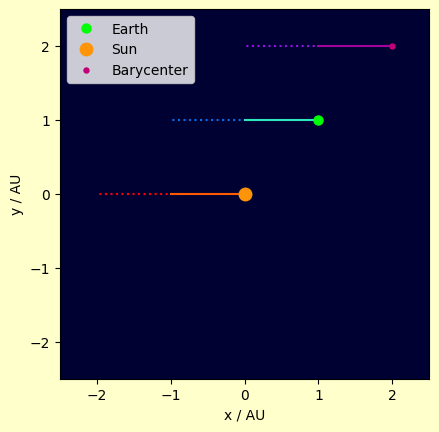

In [3]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect('equal', adjustable='box')
fig.patch.set_facecolor('xkcd:ecru')
ax.patch.set_facecolor("xkcd:very dark blue")

# test data to check colors
e_path, = plt.plot([1, -1], [1, 1], ":", color="xkcd:cerulean blue", label="_")
e_trail, = plt.plot([1, 0], [1, 1], "-", color="xkcd:aqua marine", label="_")
earth, = plt.plot([1], [1], "o", color="xkcd:bright green", label="Earth", markersize=6.5)

s_path, = plt.plot([0, -2], [0, 0], ":", color="xkcd:fire engine red", label="_")
s_trail, = plt.plot([0, -1], [0, 0], "-", color="xkcd:bright orange", label="_")
sun, = plt.plot([0], [0], "o", color="xkcd:tangerine", label="Sun", markersize=9)

b_path, = plt.plot([2, 0], [2, 2], ":", color="xkcd:violet", label="_")
b_trail, = plt.plot([2, 1], [2, 2], "-", color="xkcd:barney purple", label="_")
barycenter, = plt.plot([2], [2], "o", color="xkcd:magenta", label="Barycenter", markersize=3.6)

plt.legend()

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

plt.xlabel("x / AU")
plt.ylabel("y / AU")


md = dict(title="2-body problem", artist="Rahul Maru")
writer = PillowWriter(fps=24, metadata=md)


## Formulas
$$ F_G = \frac{G\cdot m_1 \cdot m_2}{||\vec{r}||^2} \cdot \frac {\vec{r}}{||\vec{r}||} $$

$$ GPE = \frac{G\cdot m_1 \cdot m_2}{||\vec{r}||} $$

$$ KE = \frac{1}{2} m||\vec{v}||^2 $$

The barycenter is the center of mass of the system, given by:

$$ \vec{s}_{barycenter} = {\sum_{i=1}^N \frac{\vec{s}_i}{m_i}} $$

In [4]:
# Gravitational force
G = 6.6743e-11 * T_SCALE**2 / L_SCALE**3 # [M]¯¹[L]³[T]¯²
Fg = lambda m1, m2, r: G * m1 * m2 * r/np.linalg.norm(r)**3 # [M][L][T]¯²

# energy functions  [M][L]²[T]¯²
GPE = lambda m1, m2, r: -G * m1 * m2 / np.linalg.norm(r) # gravitational potential energy
KE = lambda m, v: m * np.linalg.norm(v)**2 / 2 # kinetic energy

def calc_barycenter(particle_list: list):
	"""Calculates the barycenter (center of mass) of the system of particles."""
	Σs = np.zeros(2)
	Σm = 0
	for p in particle_list:
		Σs += p[0]*p[1]
		Σm += p[0]
	return Σs/Σm

<h1>Algorithm<h1>

## The Leap-Frog Method
The leap-frog integration method involves shifting the velocity calculations by half a time-step (midpoint summation) to improve accuracy. It goes as follows:
$$ \vec{a}_i = \frac{\vec{F}_i}{m} $$
$$ \vec{v}_{i + \frac{1}{2}} = \vec{v}_{i - \frac{1}{2}} + \vec{a}_i \Delta t $$
$$ \vec{s}_{i + 1} = \vec{s}_i + \vec{v}_{i + \frac{1}{2}} \Delta t$$

To set it up for the first timestep:
$$ \vec{v}_{\frac{1}{2}} = \vec{u} + \vec{a}_0 \frac{\Delta t}{2} $$
$$ \vec{s}_{1} = \vec{s}_0 + \vec{v}_{\frac{1}{2}} \Delta t$$



In [5]:
# leapfrog setup
F_NET = Fg(ms, me, ss-se)
ve = ue + F_NET/(2*me)
vs = us - F_NET/(2*ms)

se += ve
ss += vs


<h2>The Simulation</h2>

### Conservation
In this (and any) physical system, the sums of the linear momentum, angular momentum, and energy must be conserved.
They are calculated by the formulas:
$$\vec{p} = m \vec{v}$$
$$L = \vec{s} \times \vec{p}$$
$$U = KE + GPE$$

In [6]:
tlist = range(280)
exlist = []
eylist = []
sxlist = []
sylist = []
bxlist = []
bylist = []

plist = []
Llist = []
Ulist = []

with writer.saving(fig, "simulation.gif", 150):
	for t in tlist:
		F = Fg(ms, me, ss-se)
		ve += F/me
		vs -= F/ms
		se += ve
		ss += vs

		ex, ey = (*se,)
		sx, sy = (*ss,)
		bx, by = calc_barycenter([(me, se), (ms, ss)])

		U = GPE(me, ms, ss-se) + KE(me, ve) + KE(ms, vs)
		Ulist.append(U)
		pe = me*ve 
		ps = ms*vs
		plist.append(np.linalg.norm(pe+ps))
		L = np.cross(pe, se) + np.cross(ps, ss)
		Llist.append(np.linalg.norm(L))

		exlist.append(ex)
		eylist.append(ey)
		sxlist.append(sx)
		sylist.append(sy)
		bxlist.append(bx)
		bylist.append(by)

		s_path.set_data(sxlist, sylist)
		s_trail.set_data(sxlist[-12:], sylist[-12:])
		sun.set_data([sx], [sy])
		
		e_path.set_data(exlist, eylist)
		e_trail.set_data(exlist[-12:], eylist[-12:])
		earth.set_data([ex], [ey])
		
		b_path.set_data(bxlist, bylist)
		b_trail.set_data(bxlist[-12:], bylist[-12:])
		barycenter.set_data([bx], [by])

		writer.grab_frame()


Plot the energy, momenta to see if they are indeed conserved.

In [ ]:
plt.axhline(0, 0, max(tlist), color = "grey", linestyle="dashed", label="_")

plt.plot(tlist, plist)
plt.plot(tlist, Llist)
plt.plot(tlist, Ulist)

plt.legend(["0", "p", "L", "U"])

plt.ylim(-2e23, 8e23)

plt.show()
